In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [27]:
def bpz_prior(z, m, nt):
    
    # number of redshifts 
    nz = len(z)
    
    momin_hdf = 20.
    
    if m>32.: m = 32.
    if m<20.: m = 20.

    # nt Templates = nell Elliptical + nsp Spiral + nSB starburst
    try:  # nt is a list of 3 values
        nell, nsp, nsb = nt
    except:  # nt is a single value
        nell = 1  # 1 Elliptical in default template set
        nsp = 2   # 2 Spirals in default template set
        nsb = nt - nell - nsp  # rest Irr/SB
    
    nn = nell, nsp, nsb
    nt = sum(nn)
    
    # See Table 1 of Benitez00
    a  = 2.465,  1.806,  0.906
    zo = 0.431,  0.390,  0.0626
    km = 0.0913, 0.0636, 0.123
    k_t= 0.450,  0.147
    
    a  = np.repeat(a, nn)   # of shape 8 
    zo = np.repeat(zo, nn)  # of shape 8 
    km = np.repeat(km, nn)  # of shape 8 
    k_t= np.repeat(k_t, nn[:2])# of shape 3 (1 + 2)
    
    
    # Fractions expected at m = 20: 35% E/S0, 50% Spiral, 15% Irr
    fo_t = 0.35, 0.5
    fo_t = fo_t / np.array(nn[:2])
    fo_t = np.repeat(fo_t, nn[:2])

    dm = m-momin_hdf
    zmt = np.clip(zo+km*dm,0.01,15.) # of shape 8 
    
    zmt_at_a = zmt**(a) # of shape 8 
    zt_at_a = np.power.outer(z,a) # of shape 2999 x 8
    
    # Morphological fractions
    nellsp = nell + nsp # number of elliptical and spiral 
    f_t = np.zeros((len(a),),float)
    f_t[:nellsp] = fo_t*np.exp(-k_t*dm)
    f_t[nellsp:] = (1.-np.add.reduce(f_t[:nellsp]))/float(nsb)

    
    #Formula: zm=zo+km*(m_m_min)  and  p(z|T,m)=(z**a)*exp(-(z/zm)**a)
    p_i = zt_at_a[:nz,:nt]*np.exp(-np.clip(zt_at_a[:nz,:nt]/zmt_at_a[:nt],0.,700.))
    
    #This eliminates the very low level tails of the priors
    norm = np.add.reduce(p_i[:nz,:nt],0)

    p_i[:nz,:nt] = np.where(np.less(p_i[:nz,:nt]/norm[:nt],1e-2/float(nz)),
              0.,p_i[:nz,:nt]/norm[:nt])
    
    norm = np.add.reduce(p_i[:nz,:nt],0)
    
    p_i[:nz,:nt] = p_i[:nz,:nt]/norm[:nt]*f_t[:nt]

    return p_i

In [28]:
# This is the "fine" redshift grid we will use
z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

In [29]:
# Just some boolean indexing of templates used. Needed later for some BPZ fcts.
selectedtemplates = np.repeat(False, 8)

# Using all templates
templatetypesnb = (1, 2, 5) # nb of ellipticals, spirals, and starburst used in the 8-template library.
selectedtemplates[:] = True

# Uncomment that to use three templates using
#templatetypesnb = (1,1,1) #(1,2,8-3) 
#selectedtemplates[0:1] = True
nt = sum(templatetypesnb)

In [30]:
ellipticals = ['El_B2004a.sed'][0:templatetypesnb[0]]
spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed'][0:templatetypesnb[1]]
irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed',
           'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed'][0:templatetypesnb[2]]
template_names = [nm.replace('.sed','') for nm in ellipticals+spirals+irregulars]

# Convenient function for template names
def mknames(nt):
    return ['Elliptical '+str(i+1) for i in range(nt[0])] \
    + ['Spiral '+str(i+1) for i in range(nt[1])]\
    + ['Starburst '+str(i+1) for i in range(nt[2])]
names = mknames(templatetypesnb)

In [31]:
# Use the p(z,t,m) distribution defined above
m = 22.0 # some reference magnitude
p_z_t_m = bpz_prior(z_grid, m, templatetypesnb) # of shape 2999 x 8

[0.35 0.25]
[0.35 0.25 0.25]
[0.14229938 0.18631912 0.18631912 0.         0.         0.
 0.         0.        ]
[0.14229938 0.18631912 0.18631912 0.09701247 0.09701247 0.09701247
 0.09701247 0.09701247]


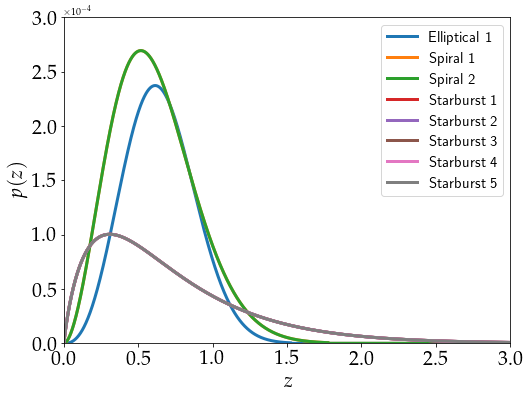

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(z_grid, p_z_t_m, lw = 3)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(labels = names, loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylim(0, 3E-4)
plt.xlim(0, 3)
plt.show()